<a href="https://colab.research.google.com/github/shourjya19b/Bayesian-Linear-Regression/blob/main/Bayesian_Linear_Regression_MHMCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math as math

In [ ]:
# Number of parameters:
npars    = 2

# Number of data points:
n = 20

# Utility vector to store mu(data)-mu(theory), temporarily:
Dmu = np.empty(n)

# ***Reading in the data***

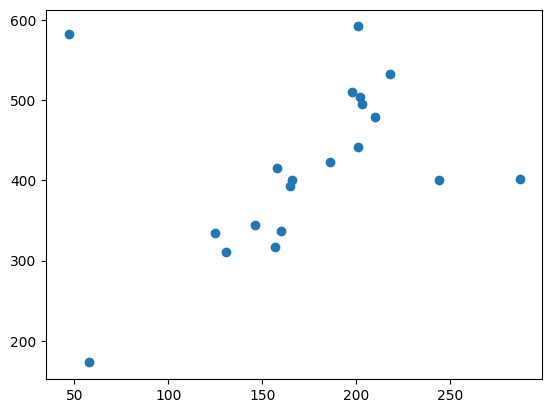

In [ ]:
# Reading in the data file:
f    = open('data.txt', 'r') # 'r' = read only
data = np.loadtxt(f)
f.close()

# For convenience, defining x , y and sigma arrays:
x  = data[:,0]
y = data[:,1]
sigma_y = data[:,2]

# Plotting the data:
plt.plot(data[:,0],data[:,1],'o')
npts    = 300
x_plot  = np.linspace(0, 300, npts)
y_plot = np.empty(npts)

# Computing Covariance Matrix for the data
cov=np.eye(n)
for i in range(n):
  cov[i,i]=sigma_y[i]**2

InvC = np.empty([n,n])
InvC = np.linalg.inv(cov)

# ***Defining Models and Likelihood functions***

In [ ]:
#Defining the model:

def model(x,m,c):
  'Straight line y = mx +c'
  y = m*x + c
  return y

#Defining the likelihood function:

def lnL(m,c):
    "Ln of likelihood for line-fitting data"

# Compute difference with theoretical y according to model, for trial m, c:
    for j in range (n):
      Dmu[j] = y[j]-model(x[j],m,c)

# Compute ln(likelihood) assuming gaussian errors (double sum done using vector/matrix ops):
    lnL = -0.5*np.dot(Dmu,np.dot(InvC,Dmu))

    return lnL

# ***Plotting theoretical lines on top of data***

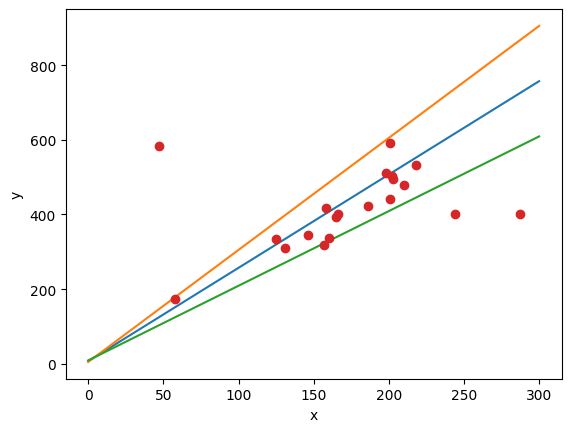

In [ ]:
# Plotting a few theoretical curves on top of the data:
for i in range (npts):
    y_plot[i] = model(x_plot[i],2.5,7)
plt.plot(x_plot,y_plot)
plt.xlabel('x')
plt.ylabel('y')

for i in range (npts):
    y_plot[i] = model(x_plot[i],3, 5)
plt.plot(x_plot,y_plot)

for i in range (npts):
    y_plot[i] = model(x_plot[i],2, 9)
plt.plot(x_plot,y_plot)

# Plot the data:
plt.plot(data[:,0],data[:,1],'o')

plt.show()

# ***Metropolis-Hastings Algorithm using a simple 'Top-Hat' Distribution***

In [ ]:
def MH_MCMC_TopHat(ns,sigma):

  # Number of MCMC samples
  nsamples=ns

  # Declare an empty array of the parameter values at each point.
  # Parameter 0 = m (Slope)
  # Parameter 1 = c (intercept)
  # Parameter npars will be used to store the ln(likelihood)
  Theta = np.empty([nsamples,npars+1])

  # Random starting point in parameter space; each parameter in range (0,1).
  # Set initial likelihood to low value so next point is accepted (could compute it instead):
  Theta[0,:] = [np.random.uniform(), np.random.uniform(), -1.e100]

  # Draw new proposed samples from a proposal distribution, centred on old values Omegam[i-1], h[i-1]
  # Accept or reject, and colour points according to ln(likelihood):

  # Compute initial likelihood value:
  Theta[0,npars] = lnL(Theta[0,0], Theta[0,1])
  acceptance_probs = np.zeros(nsamples-1)

  for i in range(1,nsamples):
      lnLPrevious = Theta[i-1,npars]
      # Assuming rectangular width of top hat to be equal to 2
      m_Prop = np.random.uniform(Theta[i-1,0]-1,Theta[i-1,0]+1)
      c_Prop = np.random.uniform(Theta[i-1,1]-1,Theta[i-1,1]+1)

      lnLProp    = lnL(m_Prop,c_Prop)

  # Metroplis-Hastings algorithm:

  # Accept sample point with probability given by ratio of likelihoods:
      alpha = np.random.uniform()
      acceptance_ratio = np.exp(np.float128(lnLProp - lnLPrevious))
      acceptance_prob = min(1, acceptance_ratio)

  #       print(lnLProp,lnLPrevious,alpha)
      if(acceptance_prob > alpha):
        Theta[i,0]     = m_Prop
        Theta[i,1]     = c_Prop
        Theta[i,npars] = lnLProp
  #       print('Accepted')
      else:
  # Repeat the previous point in the chain:
        Theta[i,0]     = Theta[i-1,0]
        Theta[i,1]     = Theta[i-1,1]
        Theta[i,npars] = lnLPrevious
  #       print('Rejected')
      acceptance_probs[i-1] = acceptance_prob

  # Remove a burn in period, arbitrarily chosen to be the first 10% of the chain:
  nburn = math.floor(nsamples/10)

  return (Theta,acceptance_probs,nburn)

# ***Metropolis-Hastings Algorithm using Gaussian Proposal Distribution***

In [ ]:
def MH_MCMC_Gaussian(ns,sigma):

  # Number of MCMC samples
  nsamples=ns

  # Define (gaussian) width of the proposal distribution, one for each parameter:
  Sigma = [sigma,sigma]

  # Declare an empty array of the parameter values at each point.
  # Parameter 0 = m (Slope)
  # Parameter 1 = c (intercept)
  # Parameter npars will be used to store the ln(likelihood)
  Theta = np.empty([nsamples,npars+1])

  # Random starting point in parameter space; each parameter in range (0,1).
  # Set initial likelihood to low value so next point is accepted (could compute it instead):
  Theta[0,:] = [np.random.uniform(), np.random.uniform(), -1.e100]

  # Draw new proposed samples from a proposal distribution, centred on old values Omegam[i-1], h[i-1]
  # Accept or reject, and colour points according to ln(likelihood):

  # Compute initial likelihood value:
  Theta[0,npars] = lnL(Theta[0,0], Theta[0,1])
  acceptance_probs = np.zeros(nsamples-1)

  for i in range(1,nsamples):
      lnLPrevious = Theta[i-1,npars]
      m_Prop = np.random.normal(Theta[i-1,0],Sigma[0])
      c_Prop = np.random.normal(Theta[i-1,1],Sigma[1])

      lnLProp    = lnL(m_Prop,c_Prop)

  # Metroplis-Hastings algorithm:

  # Accept sample point with probability given by ratio of likelihoods:
      alpha = np.random.uniform()
      acceptance_ratio = np.exp(np.float128(lnLProp - lnLPrevious))
      acceptance_prob = min(1, acceptance_ratio)

  #       print(lnLProp,lnLPrevious,alpha)
      if(acceptance_prob > alpha):
        Theta[i,0]     = m_Prop
        Theta[i,1]     = c_Prop
        Theta[i,npars] = lnLProp
  #       print('Accepted')
      else:
  # Repeat the previous point in the chain:
        Theta[i,0]     = Theta[i-1,0]
        Theta[i,1]     = Theta[i-1,1]
        Theta[i,npars] = lnLPrevious
  #       print('Rejected')
      acceptance_probs[i-1] = acceptance_prob

  # Remove a burn in period, arbitrarily chosen to be the first 10% of the chain:
  nburn = math.floor(nsamples/10)

  return (Theta,acceptance_probs,nburn)

# ***Visualising the chain and computing standard metrics***

In [ ]:
def plot_chain(Theta,nburn):

  # Scatter plot of the samples:
  plt.scatter(Theta[nburn:,0], Theta[nburn:,1], c = -Theta[nburn:,npars])
  plt.xlabel('m')
  plt.ylabel('c')
  plt.show()

  # Histogram of m (Slope):
  plt.hist(Theta[nburn:,0],bins=30,density=True)
  plt.xlabel('m')
  plt.show()

  # Histogram of c (intercept):
  plt.hist(Theta[nburn:,1],bins=30,density=True)
  plt.xlabel('c')
  plt.show()

In [ ]:
def compute_metrics(Theta,nburn):
  # Print mean of parameters, after removing a burn-in of 10% of samples:

  print ('Mean of m = ',np.mean(Theta[nburn:,0]))
  print ('Mean of c = ',np.mean(Theta[nburn:,1]))
  print ('Std of m = ',np.std(Theta[nburn:,0]))
  print ('Std of c = ',np.std(Theta[nburn:,1]))

# ***Visualisation for small proposal distribution***

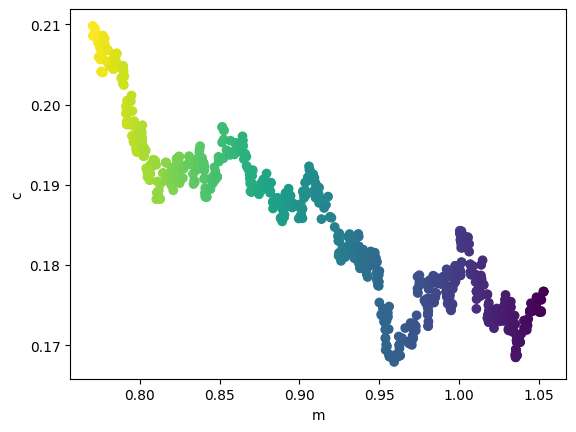

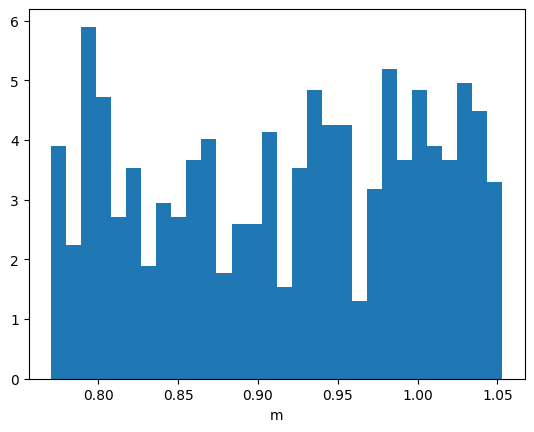

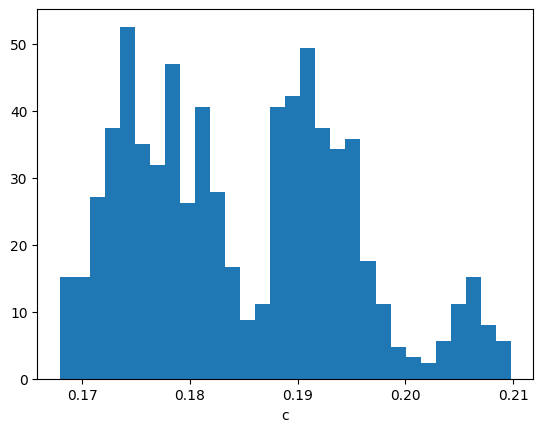

In [ ]:
(Theta,probs,nburn)=MH_MCMC_Gaussian(1000,0.001)
plot_chain(Theta,nburn)

# ***Visualisation for large proposal distribution***

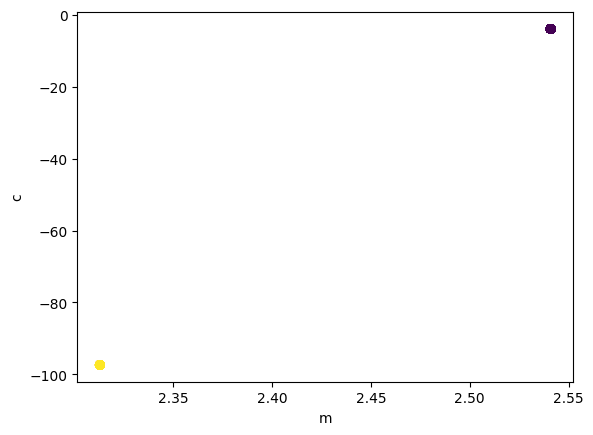

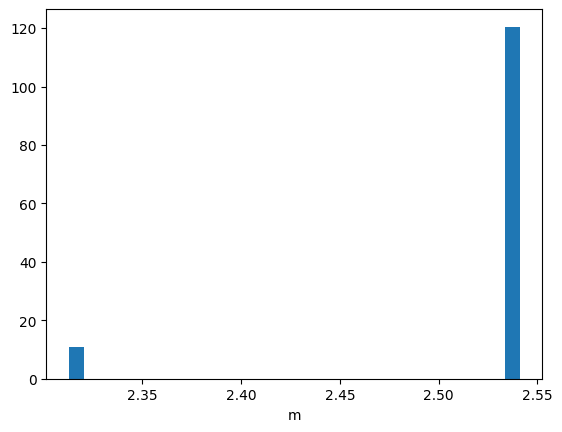

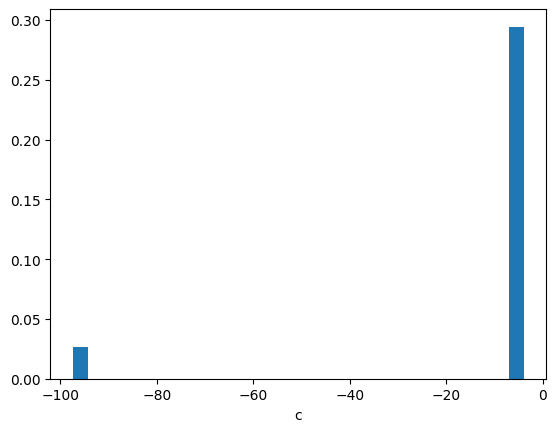

In [ ]:
(Theta,probs,nburn)=MH_MCMC_Gaussian(1000,100)
plot_chain(Theta,nburn)

# ***Acceptance probabilities for small and large proposal distributions***

In [ ]:
(Theta,probs,nburn)=MH_MCMC_Gaussian(1000,0.001)
print('Average acceptance probability =',np.mean(probs))

Average acceptance probability = 0.6270673821780037


In [ ]:
(Theta,probs,nburn)=MH_MCMC_Gaussian(1000,100)
print('Average acceptance probability =',np.mean(probs))

Average acceptance probability = 0.002002002002002002


# ***Computing standard metrics for chains of different sample sizes***

In [ ]:
# Taking proposal width as 0.01
(Theta,probs,nburn)=MH_MCMC_Gaussian(10000,0.01)
compute_metrics(Theta,nburn)

Mean of m =  2.160120762363426
Mean of c =  0.4058907730560316
Std of m =  0.024577478150566403
Std of c =  0.19331510380448155


In [ ]:
# Taking proposal width as 0.01
(Theta,probs,nburn)=MH_MCMC_Gaussian(100000,0.01)
compute_metrics(Theta,nburn)

Mean of m =  2.145670563933103
Mean of c =  3.3100618341625423
Std of m =  0.027601337427773615
Std of c =  2.2652846322380054


# ***Generating multiple chains and performing the Gelman-Rubin convergence test***

In [ ]:
def generate_chains(n_chains,nsamples):

  Thetas=np.zeros((nsamples,npars,n_chains))

  for i in range(n_chains):
    Thetas[:,:,i]=MH_MCMC_Gaussian(10000,0.01)[0][:,:2]
  return Thetas

def gelman_rubin_convergence(Thetas):

  n_chains=Thetas.shape[2]
  chain_means=np.zeros([n_chains,2])
  chain_variances=np.zeros([n_chains,2])

  for i in range(n_chains):
    chain_means[i,:]=np.mean(Thetas[:,:,i],axis=0)
    chain_variances[i,:]=np.var(Thetas[:,:,i],axis=0,ddof=1)

  #print(chain_means)
  #print(chain_variances)

  mean_var=np.mean(chain_variances,axis=0)
  var_mean=np.var(chain_means,axis=0)

  #print(mean_var)
  #print(var_mean)

  R_hat=(((n_chains-1)/n_chains)*mean_var)+(var_mean/n_chains)
  #print(R_hat)
  R_hat_m=R_hat[0]/mean_var[0]
  R_hat_c=R_hat[1]/mean_var[1]

  return (R_hat_m,R_hat_c)

In [ ]:
params=generate_chains(10,10000)

In [ ]:
(R_hat_m,R_hat_c)=gelman_rubin_convergence(params)
print(R_hat_m,R_hat_c)

0.900234186233171 1.1693944603908863


**Since *R* < 1.2 for both *m* and *c*, the chains for these parameters can be considered to have converged**

In [ ]:
l=np.array([1,2,3])
print(l[::2])

[1 3]
